In [ ]:
%pip install statsmodels

**Importing Libraries**

In [88]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_theme()

**Loading Data**

In [93]:

dataset = pd.read_csv('data_NO2.csv', sep=';')
dataset['datetime_utc'] = pd.to_datetime(dataset['datetime_utc'])


**Plot trends and seasonality**


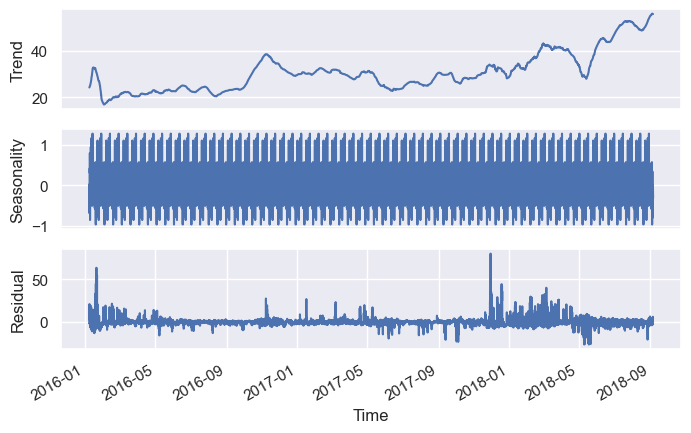

In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose


time_series = dataset[['datetime_utc', 'spot_price']]
time_series = time_series.set_index('datetime_utc')
decomposition = seasonal_decompose(time_series, model='additive', period=365)



fig, ax = plt.subplots(3, 1, figsize=(8, 5))
decomposition.trend.plot(ax=ax[0])
ax[0].set_ylabel('Trend')
ax[0].set_xticks([])
ax[0].set_xlabel('')

decomposition.seasonal.plot(ax=ax[1])
ax[1].set_ylabel('Seasonality')
ax[1].set_xticks([])
ax[1].set_xlabel('')

decomposition.resid.plot(ax=ax[2])
ax[2].set_ylabel('Residual')
ax[2].set_xlabel('Time')

plt.show()


**Plotting the relationship between the features and the target variable**

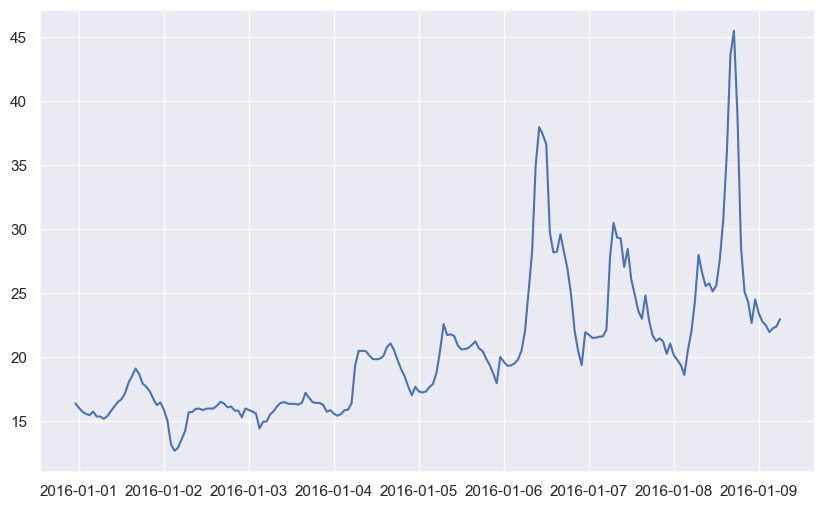

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(dataset['datetime_utc'][:200], dataset['spot_price'][:200])  # multiply by 200 to make spot price comparable to the features
plt.show()

**Finding the correlation between the features**

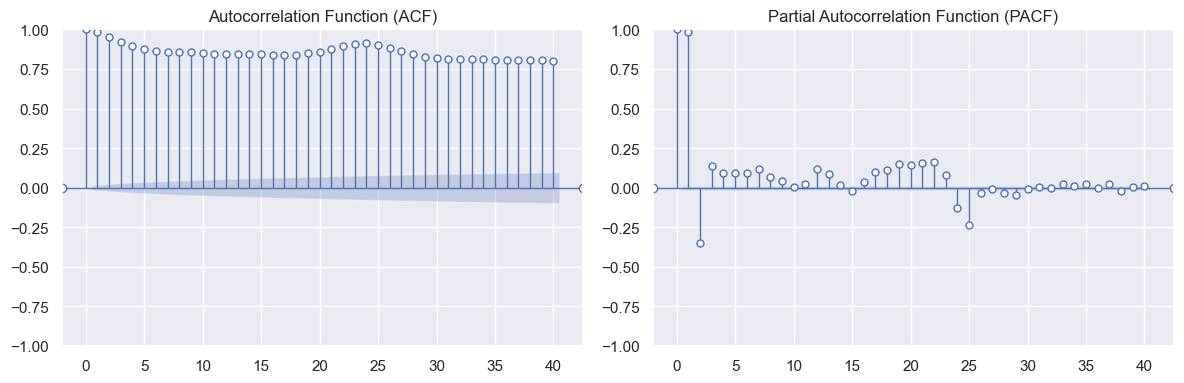

In [90]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Create subplots for ACF and PACF
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Customize ACF plot
acf_plot = plot_acf(time_series, ax=ax[0], lags=40)
ax[0].title.set_text('Autocorrelation Function (ACF)')

# Customize PACF plot
pacf_plot = plot_pacf(time_series, ax=ax[1], lags=40)
ax[1].title.set_text('Partial Autocorrelation Function (PACF)')

# Adjust bar width and spacing
for axis in ax:
    for line in axis.get_lines():
        line.set_marker('o')       # Set marker style
        line.set_markerfacecolor('white')
        line.set_markeredgewidth(1)
        line.set_linewidth(1)    # Line width for bar spacing
    for collection in axis.collections:
        collection.set_linewidth(1)  # Width of vertical lines

plt.tight_layout()
plt.show()




**Plotting Data**

**Data Preprocessing**

In [94]:
dataset['year'] = dataset['datetime_utc'].dt.year
dataset['month'] = dataset['datetime_utc'].dt.month
dataset['day'] = dataset['datetime_utc'].dt.day
dataset['time'] = dataset['datetime_utc'].dt.time
dataset['hour'] = dataset['datetime_utc'].dt.hour
dataset['spot_price_diff'] = dataset['spot_price'].diff()
dataset.drop('time', axis=1, inplace=True)
dataset["spot_price_lag1"] = dataset['spot_price'].shift(1)
dataset["spot_price_lag2"] = dataset['spot_price'].shift(2)

dataset.dropna(inplace=True)

dataset = dataset[['datetime_utc', 'year', 'month', 'day', 'hour',"volume_demand","volume_production", 'spot_price', 'spot_price_lag1', 'spot_price_lag2', 'spot_price_diff']]
dataset_for_plotting = dataset[['datetime_utc', 'spot_price']]
dataset.drop('datetime_utc', axis=1, inplace=True)

dataset.head()


,year,month,day,hour,volume_demand,volume_production,spot_price,spot_price_lag1,spot_price_lag2,spot_price_diff
2,2016,1,1,1,3930.0,7437.0,15.74,16.04,16.39,-0.30
3,2016,1,1,2,3839.0,7120.0,15.57,15.74,16.04,-0.17
4,2016,1,1,3,3833.0,7041.0,15.47,15.57,15.74,-0.10
5,2016,1,1,4,3944.0,7246.0,15.75,15.47,15.57,0.28
6,2016,1,1,5,3940.0,6860.0,15.36,15.75,15.47,-0.39


**Outlier Detection**

C:\Users\rahim\AppData\Local\Temp\ipykernel_20476\2336602995.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_for_plotting['cluster'] = dbscan.labels_


cluster
 0    23214
-1      262
 2      103
 3       46
 1       23
 4       16
Name: count, dtype: int64


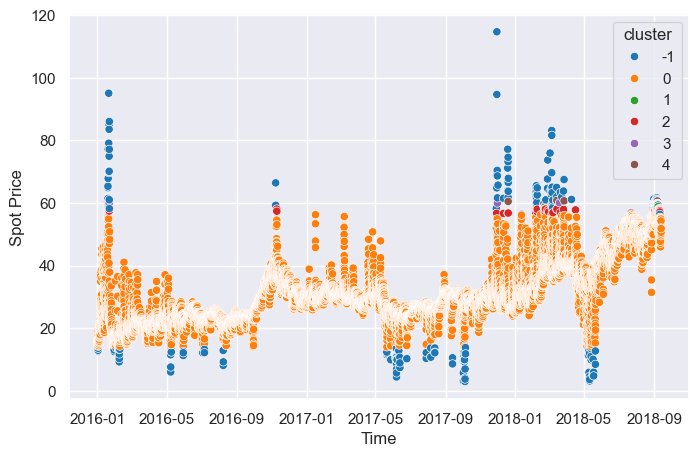

In [63]:
from sklearn.cluster import DBSCAN


dbscan = DBSCAN(eps=0.1, min_samples=10)



dbscan.fit(dataset[['spot_price']])
dataset_for_plotting['cluster'] = dbscan.labels_
dataset['cluster'] = dbscan.labels_

print(dataset_for_plotting['cluster'].value_counts())


plt.figure(figsize=(8, 5))
sns.scatterplot(x='datetime_utc', y='spot_price', data=dataset_for_plotting, hue='cluster', palette='tab10', hue_order=[ -1,0,1, 2, 3, 4])
plt.xlabel('Time')
plt.ylabel('Spot Price')
plt.show()


dataset = dataset[dataset['cluster'] != -1]
dataset_for_plotting = dataset_for_plotting[dataset_for_plotting['cluster'] != -1]
dataset.drop('cluster', axis=1, inplace=True)
dataset_for_plotting.drop('cluster', axis=1, inplace=True)

In [66]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
dataset[[  'spot_price_lag1', 'spot_price_lag2','spot_price_diff' ]] = scaler.fit_transform(dataset[[ 'spot_price_lag1', 'spot_price_lag2','spot_price_diff' ]])

**Train Test Split**

In [81]:
from sklearn.model_selection import train_test_split


train, test = train_test_split(dataset, test_size=0.2, random_state=42, shuffle=False)

y_train = train['spot_price']
y_test = test['spot_price']
X_train = train.drop('spot_price', axis=1)
X_test = test.drop('spot_price', axis=1)



Decision Tree RMSE: 0.99
Decision Tree MAE: 0.63


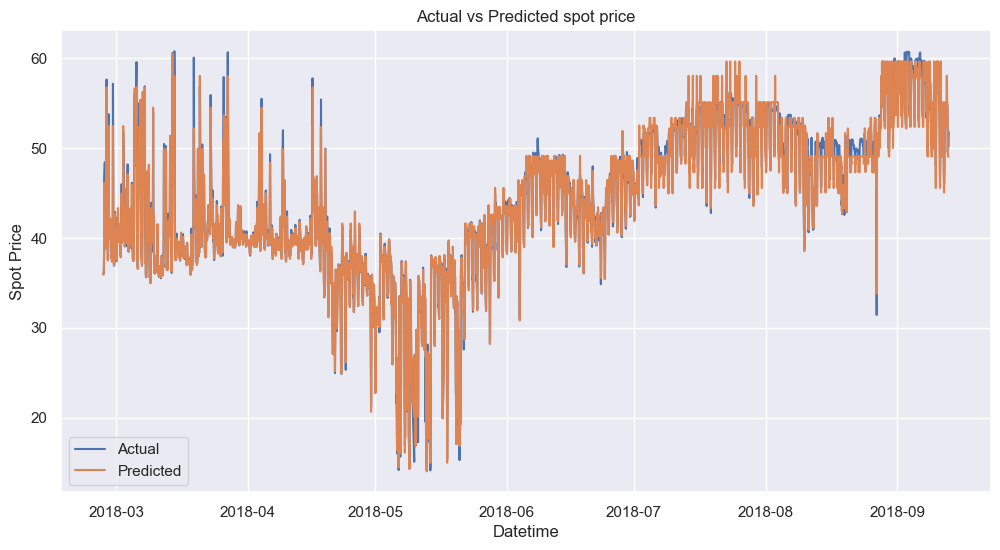

,datetime_utc,spot_price,predicted_spot_price
18886,2018-02-25 23:00:00+00:00,36.03,36.06
18887,2018-02-26 00:00:00+00:00,36.04,35.92
18888,2018-02-26 01:00:00+00:00,36.04,35.92
18889,2018-02-26 02:00:00+00:00,36.12,36.10
18890,2018-02-26 03:00:00+00:00,36.75,36.86


In [82]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import root_mean_squared_error, mean_absolute_error


tree = DecisionTreeRegressor(random_state=42)
tree.fit(X_train, y_train)

y_pred_tree = tree.predict(X_test)

rmse_tree = root_mean_squared_error(y_test, y_pred_tree)
mae_tree = mean_absolute_error(y_test, y_pred_tree)

print(f'Decision Tree RMSE: {rmse_tree:.2f}')
print(f'Decision Tree MAE: {mae_tree:.2f}')





test_indices = test.index
test_with_datetime = dataset_for_plotting.loc[test_indices]
test_with_datetime['predicted_spot_price'] = y_pred_tree

plt.figure(figsize=(12, 6))
sns.lineplot(x='datetime_utc', y='spot_price', data=test_with_datetime, label='Actual')
sns.lineplot(x='datetime_utc',y='predicted_spot_price', data=test_with_datetime, label='Predicted')

plt.title('Actual vs Predicted spot price')
plt.xlabel('Datetime')
plt.ylabel('Spot Price')
plt.show()

test_with_datetime.head()



RMSE: 4.826716025780638
MAE: 3.5590482046427794


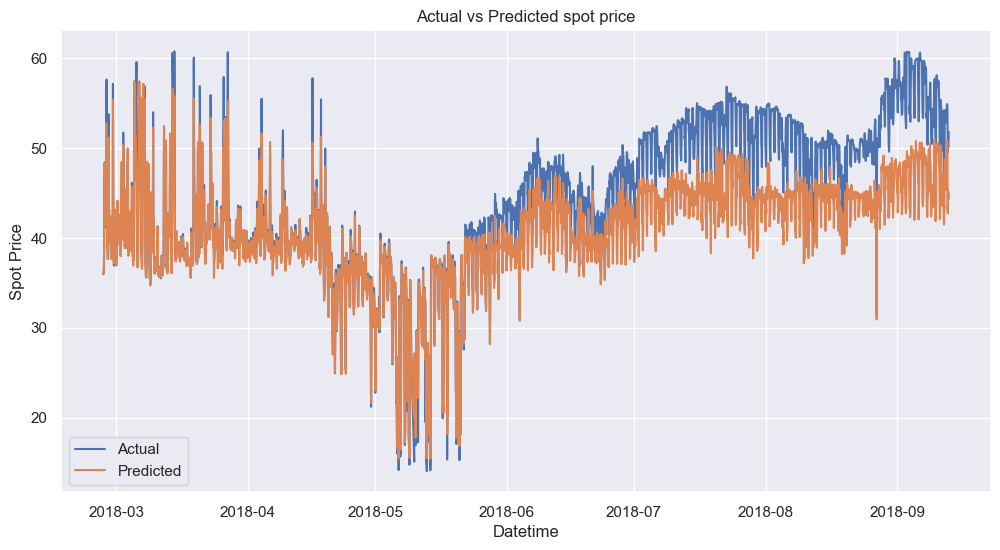

          Feature Id  Importances
0    spot_price_lag1    64.827160
1    spot_price_diff    14.964978
2    spot_price_lag2    13.077768
3  volume_production     1.766728
4               year     1.443043
5              month     1.248115
6      volume_demand     1.215368
7               hour     0.925916
8                day     0.530924


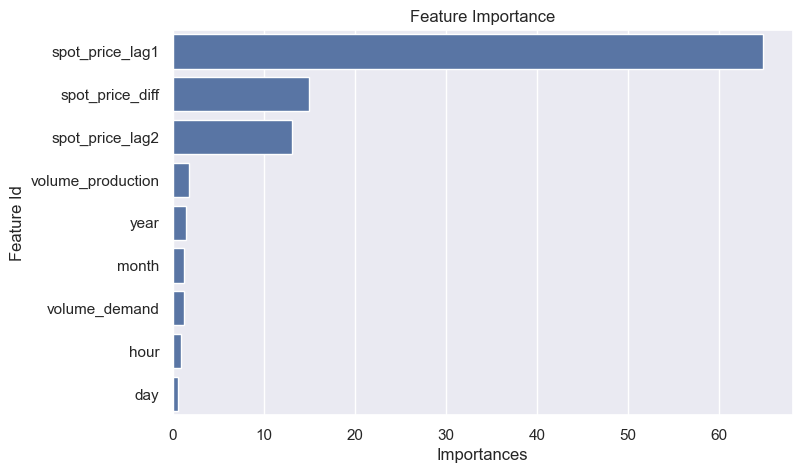

In [83]:
from catboost import CatBoostRegressor


cat = CatBoostRegressor(iterations=995, learning_rate=0.09302257233123135, depth=10, loss_function='RMSE', verbose=0, random_state=42)
cat.fit(X_train, y_train)
y_pred = cat.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')



test_indices = test.index
test_with_datetime = dataset_for_plotting.loc[test_indices]
test_with_datetime['predicted_spot_price'] = y_pred

plt.figure(figsize=(12, 6))
sns.lineplot(x='datetime_utc', y='spot_price', data=test_with_datetime, label='Actual')
sns.lineplot(x='datetime_utc',y='predicted_spot_price', data=test_with_datetime, label='Predicted')

plt.title('Actual vs Predicted spot price')
plt.xlabel('Datetime')
plt.ylabel('Spot Price')
plt.show()

# feature importance

feature_importance = cat.get_feature_importance(prettified=True)
print(feature_importance)
plt.figure(figsize=(8, 5))
sns.barplot(x='Importances', y='Feature Id', data=feature_importance)
plt.title('Feature Importance')
plt.show()



Mean Absolute Error: 0.3511741080965634
Root Mean Squared Error: 0.715484040894733


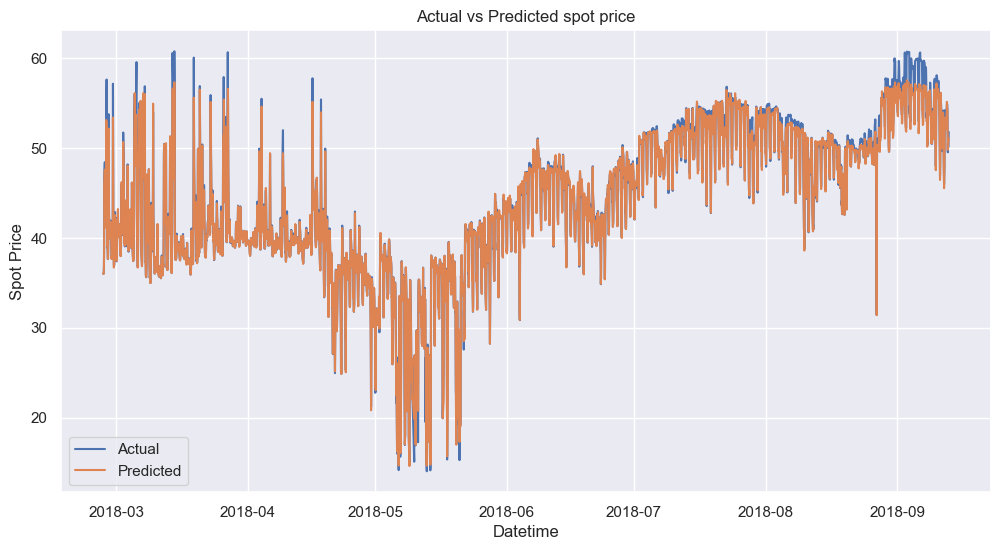

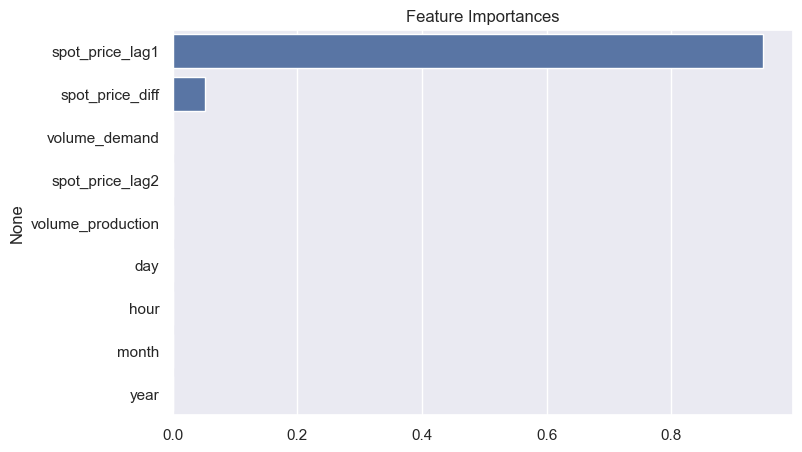

In [84]:
from sklearn.ensemble import RandomForestRegressor


model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}') 
print(f'Root Mean Squared Error: {rmse}') 

test_indices = test.index
test_with_datetime = dataset_for_plotting.loc[test_indices]
test_with_datetime['predicted_spot_price'] = y_pred

plt.figure(figsize=(12, 6))
sns.lineplot(x='datetime_utc', y='spot_price', data=test_with_datetime, label='Actual')
sns.lineplot(x='datetime_utc',y='predicted_spot_price', data=test_with_datetime, label='Predicted')
plt.title('Actual vs Predicted spot price')
plt.xlabel('Datetime')
plt.ylabel('Spot Price')
plt.show()



# feature importance

importances = model.feature_importances_
features = X_train.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(8, 5))
plt.title('Feature Importances')
sns.barplot(x=importances[indices], y=features[indices])
plt.show()


Mean Aboslute Error: 0.3248048778478554
Root Mean Squared Error: 0.5775803832783352


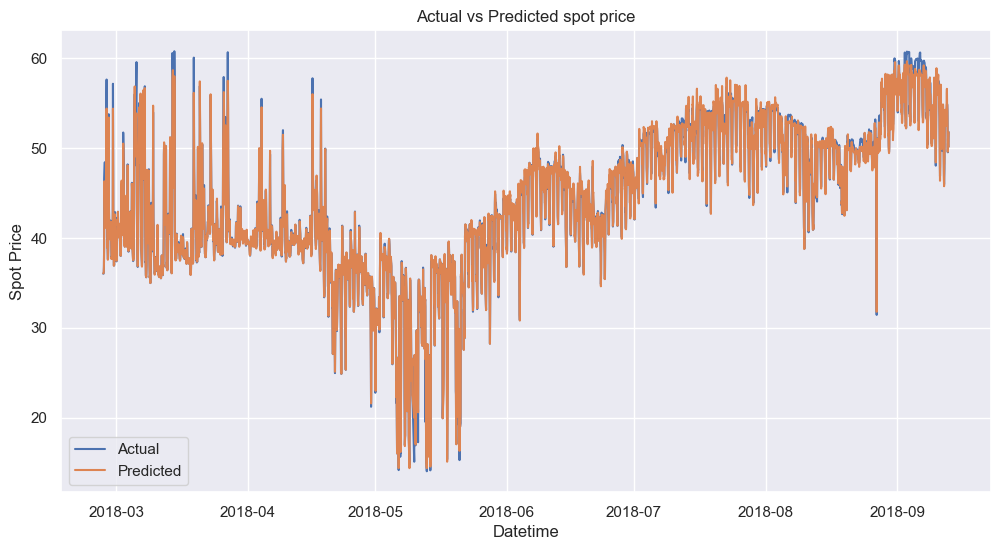

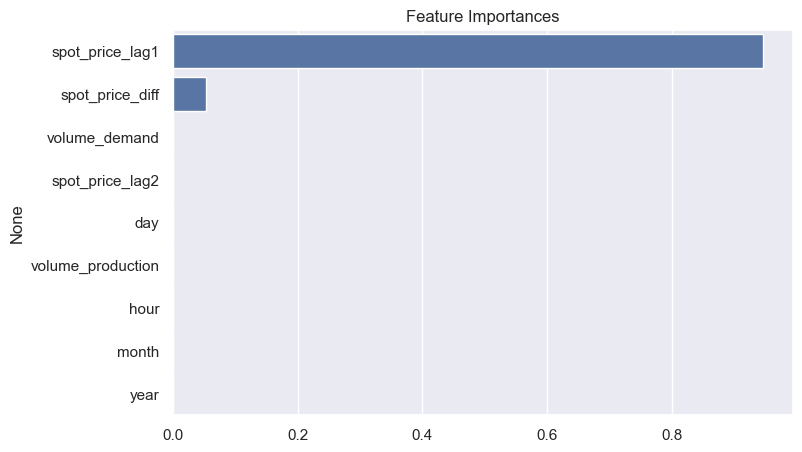

In [85]:
from sklearn.ensemble import GradientBoostingRegressor

model = GradientBoostingRegressor(learning_rate=0.15200744571172792, n_estimators= 150, max_depth= 8, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
print(f'Mean Aboslute Error: {mae}') 
print(f'Root Mean Squared Error: {rmse}')

test_indices = test.index
test_with_datetime = dataset_for_plotting.loc[test_indices]
test_with_datetime['predicted_spot_price'] = y_pred

plt.figure(figsize=(12, 6))
sns.lineplot(x='datetime_utc', y='spot_price', data=test_with_datetime, label='Actual')
sns.lineplot(x='datetime_utc',y='predicted_spot_price', data=test_with_datetime, label='Predicted')
plt.title('Actual vs Predicted spot price')
plt.xlabel('Datetime')
plt.ylabel('Spot Price')
plt.show()


importances = model.feature_importances_
features = X_train.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(8, 5))
plt.title('Feature Importances')
sns.barplot(x=importances[indices], y=features[indices])
plt.show()


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000204 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1348
[LightGBM] [Info] Number of data points in the train set: 18721, number of used features: 9
[LightGBM] [Info] Start training from score 27.502231
Mean Absolute Error: 0.938142174873599
Root Mean Squared Error: 1.5391187358565637


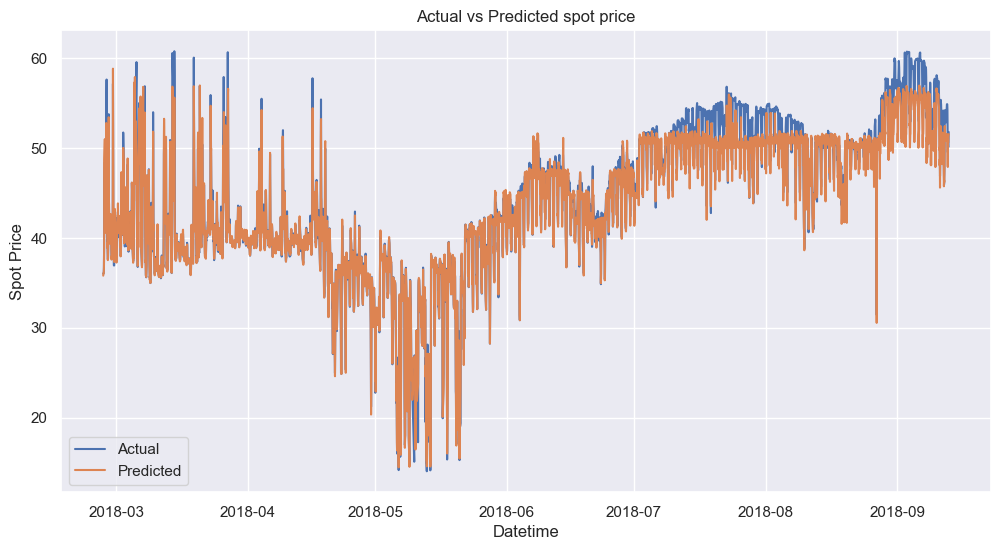

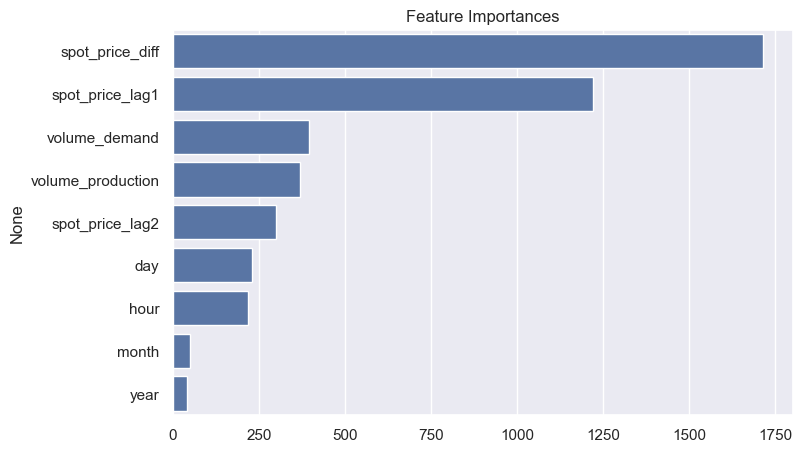

In [86]:
from lightgbm import LGBMRegressor
model = LGBMRegressor(random_state=42, learning_rate = 0.10098970302898683, n_estimators = 142, max_depth = 19, num_leaves = 33)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {rmse}')


test_indices = test.index
test_with_datetime = dataset_for_plotting.loc[test_indices]
test_with_datetime['predicted_spot_price'] = y_pred

plt.figure(figsize=(12, 6))
sns.lineplot(x='datetime_utc', y='spot_price', data=test_with_datetime, label='Actual')
sns.lineplot(x='datetime_utc',y='predicted_spot_price', data=test_with_datetime, label='Predicted')
plt.title('Actual vs Predicted spot price')
plt.xlabel('Datetime')
plt.ylabel('Spot Price')
plt.show()

# feature importance

importances = model.feature_importances_
features = X_train.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(8, 5))
plt.title('Feature Importances')
sns.barplot(x=importances[indices], y=features[indices])
plt.show()


Root Mean Squared Error: 2.4041184231622443
Mean Absolute Error: 1.507355233974575


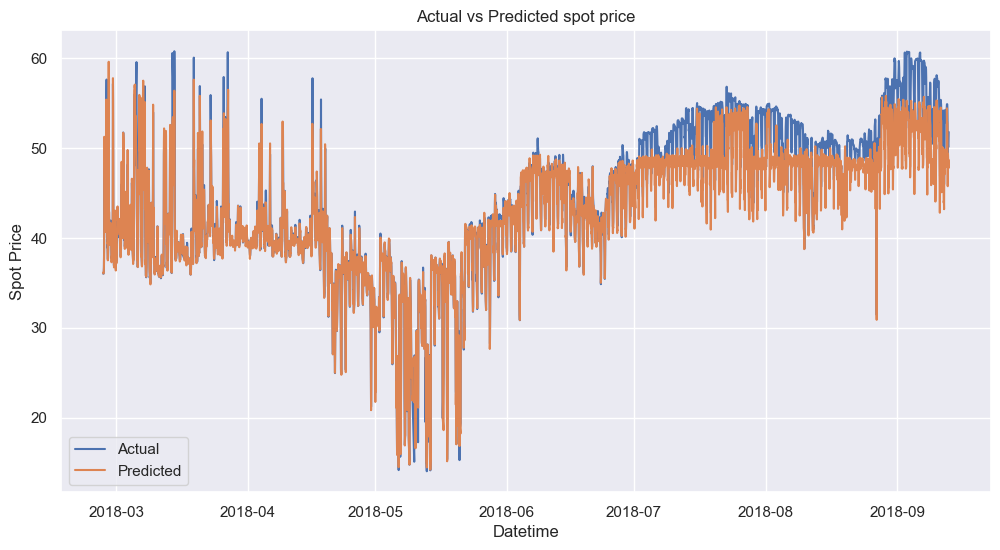

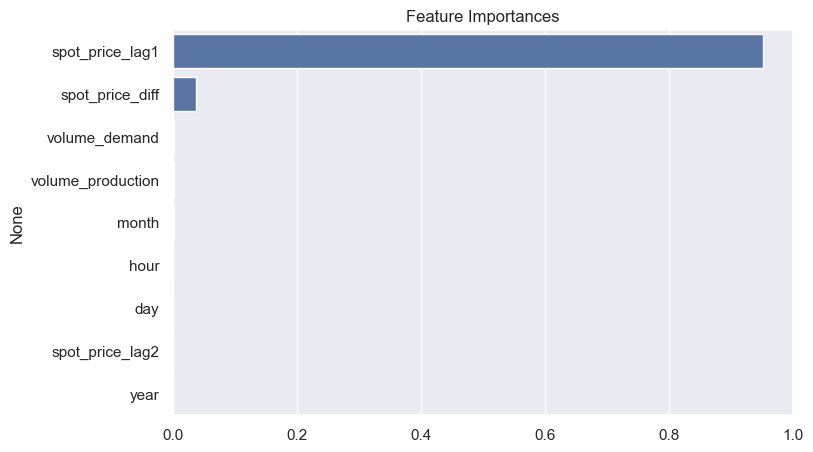

In [87]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error


model = XGBRegressor(learning_rate=0.20290470560630897, n_estimators= 132, max_depth= 6, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Absolute Error: {mae}')

test_indices = test.index
test_with_datetime = dataset_for_plotting.loc[test_indices]
test_with_datetime['predicted_spot_price'] = y_pred

plt.figure(figsize=(12, 6))
sns.lineplot(x='datetime_utc', y='spot_price', data=test_with_datetime, label='Actual')
sns.lineplot(x='datetime_utc',y='predicted_spot_price', data=test_with_datetime, label='Predicted')
plt.title('Actual vs Predicted spot price')
plt.xlabel('Datetime')
plt.ylabel('Spot Price')
plt.show()


importances = model.feature_importances_
features = X_train.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(8, 5))
plt.title('Feature Importances')
sns.barplot(x=importances[indices], y=features[indices])
plt.show()


In [149]:
import optuna


def objective(trial):
    learning_rate = trial.suggest_float('learning_rate', 0.1, 1)
    model = XGBRegressor(learning_rate=learning_rate, n_estimators= 132, max_depth= 6, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = root_mean_squared_error(y_test, y_pred)
    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)


[I 2024-10-23 15:48:08,209] A new study created in memory with name: no-name-cd0b9908-4622-42c0-bc14-f8d7b82fa5bf
[I 2024-10-23 15:48:08,344] Trial 0 finished with value: 1.9231242024214819 and parameters: {'learning_rate': 0.1670646846873647}. Best is trial 0 with value: 1.9231242024214819.
[I 2024-10-23 15:48:08,467] Trial 1 finished with value: 2.4026400849084615 and parameters: {'learning_rate': 0.5976134241726104}. Best is trial 0 with value: 1.9231242024214819.
[I 2024-10-23 15:48:08,585] Trial 2 finished with value: 2.370258902092906 and parameters: {'learning_rate': 0.7517385714415855}. Best is trial 0 with value: 1.9231242024214819.
[I 2024-10-23 15:48:08,702] Trial 3 finished with value: 2.456018958097437 and parameters: {'learning_rate': 0.7155827830556727}. Best is trial 0 with value: 1.9231242024214819.
[I 2024-10-23 15:48:08,819] Trial 4 finished with value: 1.9265718465688304 and parameters: {'learning_rate': 0.21548587523160506}. Best is trial 0 with value: 1.9231242024